In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/raw/dataset_creditscoring.csv")

In [3]:
df.shape

(7180, 30)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7180 entries, 0 to 7179
Data columns (total 30 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            7180 non-null   int64  
 1   banca                                                 7180 non-null   object 
 2   tipocredito                                           7180 non-null   object 
 3   sector_final                                          7180 non-null   object 
 4   tipocontribuyente                                     7180 non-null   object 
 5   NumeroTrabajadores                                    7167 non-null   float64
 6   MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M  4393 non-null   float64
 7   MAX_CNT_ENTIDADES_SSFF_06M                            7172 non-null   float64
 8   SD_MAX_DIAS_MORA_SSFF_06M                             7132

In [5]:
df.columns

Index(['Unnamed: 0', 'banca', 'tipocredito', 'sector_final',
       'tipocontribuyente', 'NumeroTrabajadores',
       'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M',
       'MAX_CNT_ENTIDADES_SSFF_06M', 'SD_MAX_DIAS_MORA_SSFF_06M',
       'CAT_ENTFIN_PRINCIPAL_01M', 'CAT_PRODUCTOS_SSFF_01M',
       'MAX_X_CLASIF_12M', 'ANTIGUEDAD_RCC_01M', 'flag_ratios_aprobados',
       'AUDITADO_1_PERIODO', 'AUDITADO_2_PERIODO', 'SITUACION_1_PERIODO',
       'SITUACION_2_PERIODO', 'AUDITADO_1_TOTAL_INGRESOS_BRUTOS',
       'EF_VAR_VENTAS_2a', 'EF_VAR_INMUEBLE_MAQ_EQUIPO_2a',
       'EF_DIF_PROMEDIO_PAGOS_DIAS_2a', 'EF_ROTACION_INVENTARIOS_1a',
       'EF_COBERTURA_SERVICIO_DEUDA_1a',
       'EF_ActivosCirculante_PasivoCirculante_1a',
       'EF_Cajasbancos_PasivoExigible_1a',
       'EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a', 'malo_sf_inicio', 'target_y',
       'periodo'],
      dtype='object')

Filtros del modelo

In [6]:
df = df[
    (df['malo_sf_inicio'] == "pasa_filtros_sf") &
    (df['target_y'].isin([0, 1])) &  # solo buenos y malos
    (df['flag_ratios_aprobados'] == 1) &  # estados financieros auditados
    (df['AUDITADO_1_TOTAL_INGRESOS_BRUTOS'] >= 1000) &  # mediana empresa
    (df['AUDITADO_1_TOTAL_INGRESOS_BRUTOS'] <= 30000) &  # mediana empresa
    (df['tipocredito'] == 'Colocacion') &
    (df['periodo'] <= 201911)
]

1. Definición de malo

| Categoría     | Descripción  |
|:-----------------------------------|:-----------------------------------|
| Malo          | Presenta días de atraso mayor a 30 días o clasificación mayor a CPP o Refinanciado o castigado o reestructurado en los siguientes 3 meses|
| Bueno         | Se mantuvo en 0 días de atraso en los siguientes 3|
| Indeterminado | resto|

Para fines de modelamiento los indeterminados serán excluidos del análisis, pero sí se aplicará el modelo sobre ellos.

2. Volumetrías

2.1 Cantidad por periodo y target

In [16]:
b = pd.crosstab(df['periodo'], df['target_y'])
# Calcular columnas 'Total'
b['Total'] = b.sum(axis=1)

# Cambiar los nombres de las columnas
b.columns = ['Buenos', 'Malos', 'Total']
b

,Buenos,Malos,Total
periodo,,,
201701,90,38,128
201702,97,55,152
201703,102,53,155
201704,102,47,149
201705,92,48,140
201706,98,56,154
201707,107,55,162
201708,119,46,165
201709,120,38,158


Tasa de malos

In [18]:
# Calcular tabla de frecuencia
b = pd.crosstab(df['periodo'], df['target_y'])

# Calcular la tasa de malos
a = b.div(b.sum(axis=1), axis=0).round(4)

# Concatenar columnas y calcular la tasa de malos en porcentaje
c = pd.concat([b.iloc[:,0], b.iloc[:,1], b.sum(axis=1), a.iloc[:,1] * 100], axis=1)
c.columns = ['Buenos', 'Malos', 'Total', 'TasaMalos%']

c

,Buenos,Malos,Total,TasaMalos%
periodo,,,,
201701,90,38,128,29.69
201702,97,55,152,36.18
201703,102,53,155,34.19
201704,102,47,149,31.54
201705,92,48,140,34.29
201706,98,56,154,36.36
201707,107,55,162,33.95
201708,119,46,165,27.88
201709,120,38,158,24.05


Periodo de desarrollo vs periodo backtesting

In [7]:
# Filtrar para el desarrollo del modelo
data_model = df[df['periodo'] <= 201906]

# Filtrar para las pruebas de retroceso
backtest = df[df['periodo'] >= 201907]

In [ ]:
# Eliminar 'df' si es necesario
del df

Testing and training sets

In [11]:
from sklearn.model_selection import train_test_split

# Crear un DataFrame de pandas a partir de 'data_model'
X = data_model.drop(columns=['target_y'])
y = data_model[['target_y']]

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3000, stratify=y)

# Ver las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Dimensiones del conjunto de prueba:", X_test.shape, y_test.shape)

Dimensiones del conjunto de entrenamiento: (4084, 29) (4084, 1)
Dimensiones del conjunto de prueba: (1751, 29) (1751, 1)


In [10]:
from sklearn.model_selection import train_test_split

# Crear un DataFrame de pandas a partir de 'backtest'
X_backtest = backtest.drop(columns=['target_y'])
y_backtest = backtest[['target_y']]

2.4 Train & Test

Train

In [27]:
# Calcular tabla de frecuencia
b = pd.crosstab(X_train['periodo'], y_train['target_y'])

# Calcular la tasa de malos
a = b.div(b.sum(axis=1), axis=0).round(4)

# Concatenar columnas y calcular la tasa de malos en porcentaje
c = pd.concat([b.iloc[:,0], b.iloc[:,1], b.sum(axis=1), a.iloc[:,1] * 100], axis=1)
c.columns = ['Buenos', 'Malos', 'Total', 'TasaMalos%']

c

,Buenos,Malos,Total,TasaMalos%
periodo,,,,
201701,63,25,88,28.41
201702,71,39,110,35.45
201703,77,40,117,34.19
201704,79,36,115,31.30
201705,56,28,84,33.33
201706,71,42,113,37.17
201707,75,39,114,34.21
201708,84,30,114,26.32
201709,89,25,114,21.93


test

In [28]:
# Calcular tabla de frecuencia
b = pd.crosstab(X_test['periodo'], y_test['target_y'])

# Calcular la tasa de malos
a = b.div(b.sum(axis=1), axis=0).round(4)

# Concatenar columnas y calcular la tasa de malos en porcentaje
c = pd.concat([b.iloc[:,0], b.iloc[:,1], b.sum(axis=1), a.iloc[:,1] * 100], axis=1)
c.columns = ['Buenos', 'Malos', 'Total', 'TasaMalos%']

c

,Buenos,Malos,Total,TasaMalos%
periodo,,,,
201701,27,13,40,32.50
201702,26,16,42,38.10
201703,25,13,38,34.21
201704,23,11,34,32.35
201705,36,20,56,35.71
201706,27,14,41,34.15
201707,32,16,48,33.33
201708,35,16,51,31.37
201709,31,13,44,29.55


2.5 Backtest

In [31]:
# Calcular tabla de frecuencia
b = pd.crosstab(X_backtest['periodo'], y_backtest['target_y'])

# Calcular la tasa de malos
a = b.div(b.sum(axis=1), axis=0).round(4)

# Concatenar columnas y calcular la tasa de malos en porcentaje
c = pd.concat([b.iloc[:,0], b.iloc[:,1], b.sum(axis=1), a.iloc[:,1] * 100], axis=1)
c.columns = ['Buenos', 'Malos', 'Total', 'TasaMalos%']

c

,Buenos,Malos,Total,TasaMalos%
periodo,,,,
201907,210,56,266,21.05
201908,224,52,276,18.84
201909,224,44,268,16.42
201910,213,51,264,19.32
201911,223,48,271,17.71


2.6 Resumen %Malos por muestra

In [33]:
import pandas as pd

# Suponiendo que 'train', 'test' y 'backtest' son tus DataFrames de pandas.

# Calcular la proporción de clases en los conjuntos de datos
a = (y_train['target_y'].value_counts(normalize=True) * 100).round(2)
b = (y_test['target_y'].value_counts(normalize=True) * 100).round(2)
c = (backtest['target_y'].value_counts(normalize=True) * 100).round(2)

# Crear un DataFrame combinando las proporciones
d = pd.DataFrame([a, b, c])
d.index = ['train', 'test', 'backtest']
d.columns = ['%Buenos', '%Malos']
d

,%Buenos,%Malos
train,74.17,25.83
test,74.19,25.81
backtest,81.34,18.66


3. Análisis univariado y bivariado

3.1 Univariado

Univariados

In [34]:
# Resumir las columnas del conjunto de datos de entrenamiento
univariate = pd.DataFrame(X_train.drop(columns=['periodo']).describe())

# Renombrar la columna de variables
univariate.rename_axis('Variable', inplace=True)

# Mostrar el resumen de las columnas
print(univariate)

           Unnamed: 0  NumeroTrabajadores  \
Variable                                    
count     4084.000000         4077.000000   
mean      3631.393976           35.227373   
std       2081.016667           86.464609   
min          2.000000            0.000000   
25%       1837.750000            6.000000   
50%       3639.000000           14.000000   
75%       5432.250000           31.000000   
max       7180.000000         1433.000000   

          MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M  \
Variable                                                         
count                                          2.506000e+03      
mean                                           4.042156e-01      
std                                            4.796325e-01      
min                                            1.930000e-08      
25%                                            6.761720e-04      
50%                                            2.127475e-02      
75%                  

IV referencial

In [14]:
y_train.shape, X_train.shape

((4084, 1), (4084, 29))

In [30]:
import scorecardpy as sc

# Seleccionar columnas excluyendo 'periodo' y preparar los datos para el cálculo de IV
train_for_iv = X_train.drop(columns=['periodo'])

df = pd.concat([train_for_iv, y_train], axis=1)

# Calcular el IV utilizando scorecardpy
iv_table = sc.iv(df, y='target_y')
iv_table

,variable,info_value
19,SD_MAX_DIAS_MORA_SSFF_06M,1.657776
14,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTF...,1.546220
4,AUDITADO_1_TOTAL_INGRESOS_BRUTOS,1.458053
23,EF_COBERTURA_SERVICIO_DEUDA_1a,1.405002
16,EF_ActivosCirculante_PasivoCirculante_1a,1.391759
11,EF_Cajasbancos_PasivoExigible_1a,1.386531
24,EF_VAR_VENTAS_2a,1.342707
17,EF_VAR_INMUEBLE_MAQ_EQUIPO_2a,1.242920
10,EF_ROTACION_INVENTARIOS_1a,1.089386
25,NumeroTrabajadores,0.903146


In [28]:
# Convertir el IV a un DataFrame de pandas para facilitar la fusión
iv_df = iv_table.reset_index().rename(columns={'index': 'Variable', 'iv': 'IV'})

# Resumen univariante de las columnas (usando describe() y transponiendo para alinear con la estructura de IV)
univariate_summary = X_train.describe().transpose().reset_index().rename(columns={'index': 'Variable'})

# Fusión del resumen univariante con el IV
merged_table = pd.concat([univariate_summary, iv_df], axis=1)

# Mostrar la tabla fusionada
merged_table

,Variable,count,mean,std,min,25%,50%,75%,max,Variable,variable,info_value
0,Unnamed: 0,4084.0,3631.393976,2081.016667,2.000000e+00,1837.750000,3639.000000,5432.250000,7180.000000,19,SD_MAX_DIAS_MORA_SSFF_06M,1.657776
1,NumeroTrabajadores,4077.0,35.227373,86.464609,0.000000e+00,6.000000,14.000000,31.000000,1433.000000,14,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTF...,1.546220
2,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTF...,2506.0,0.404216,0.479632,1.930000e-08,0.000676,0.021275,1.000000,1.000000,4,AUDITADO_1_TOTAL_INGRESOS_BRUTOS,1.458053
3,MAX_CNT_ENTIDADES_SSFF_06M,4079.0,3.872273,1.648669,1.000000e+00,3.000000,4.000000,5.000000,10.000000,23,EF_COBERTURA_SERVICIO_DEUDA_1a,1.405002
4,SD_MAX_DIAS_MORA_SSFF_06M,4057.0,4.819999,10.729169,0.000000e+00,0.000000,0.516398,5.501515,192.610920,16,EF_ActivosCirculante_PasivoCirculante_1a,1.391759
5,CAT_ENTFIN_PRINCIPAL_01M,4062.0,44.048006,45.885873,1.000000e+00,4.000000,6.000000,82.000000,236.000000,11,EF_Cajasbancos_PasivoExigible_1a,1.386531
6,MAX_X_CLASIF_12M,4075.0,0.177669,0.518998,0.000000e+00,0.000000,0.000000,0.000000,4.000000,24,EF_VAR_VENTAS_2a,1.342707
7,ANTIGUEDAD_RCC_01M,4077.0,37.795193,9.590742,0.000000e+00,31.000000,39.000000,46.000000,52.000000,17,EF_VAR_INMUEBLE_MAQ_EQUIPO_2a,1.242920
8,flag_ratios_aprobados,4084.0,1.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,10,EF_ROTACION_INVENTARIOS_1a,1.089386
9,AUDITADO_1_PERIODO,4084.0,201707.739471,77.881997,2.015120e+05,201612.000000,201712.000000,201812.000000,201812.000000,25,NumeroTrabajadores,0.903146


Estos valores son distintos a los obtenidos con R.

Bivariados iniciales

In [31]:
# Seleccionar columnas del DataFrame 'train'
selected = [
    "target_y",
    "sector_final",
    "tipocontribuyente",
    "NumeroTrabajadores",
    "MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M",
    "MAX_CNT_ENTIDADES_SSFF_06M",
    "SD_MAX_DIAS_MORA_SSFF_06M",
    "CAT_ENTFIN_PRINCIPAL_01M",
    "CAT_PRODUCTOS_SSFF_01M",
    "MAX_X_CLASIF_12M",
    "ANTIGUEDAD_RCC_01M",
    "EF_VAR_VENTAS_2a",
    "EF_VAR_INMUEBLE_MAQ_EQUIPO_2a",
    "EF_DIF_PROMEDIO_PAGOS_DIAS_2a",
    "EF_ROTACION_INVENTARIOS_1a",
    "EF_COBERTURA_SERVICIO_DEUDA_1a",
    "EF_ActivosCirculante_PasivoCirculante_1a",
    "EF_Cajasbancos_PasivoExigible_1a",
    "EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a"
]

# Filtrar 'train' seleccionando las columnas deseadas
selected_train = df[selected]

# Generar bins utilizando scorecardpy
bins = sc.woebin(
    selected_train,
    y='target_y',
    # min_perc_fine_bin=0.02,
    min_perc_coarse_bin=0.05,
    stop_limit=0.02,
    max_num_bin=6,
    method='tree'
)

bins

[INFO] creating woe binning ...


p:\maestriaDS\cursos\c2-5-advancedSupervisedML\env\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
p:\maestriaDS\cursos\c2-5-advancedSupervisedML\env\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
p:\maestriaDS\cursos\c2-5-advancedSupervisedML\env\Lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer format, so eac

Binning on 4084 rows and 19 columns in 00:00:29


{'CAT_ENTFIN_PRINCIPAL_01M':                    variable          bin  count  count_distr  good  bad  \
 0  CAT_ENTFIN_PRINCIPAL_01M      missing     22     0.005387    20    2   
 1  CAT_ENTFIN_PRINCIPAL_01M  [-inf,60.0)   2269     0.555583  1599  670   
 2  CAT_ENTFIN_PRINCIPAL_01M  [60.0,90.0)   1558     0.381489  1247  311   
 3  CAT_ENTFIN_PRINCIPAL_01M   [90.0,inf)    235     0.057542   163   72   
 
     badprob       woe    bin_iv  total_iv   breaks  is_special_values  
 0  0.090909 -1.247893  0.005874  0.068159  missing               True  
 1  0.295284  0.184836  0.019810  0.068159     60.0              False  
 2  0.199615 -0.334011  0.039046  0.068159     90.0              False  
 3  0.306383  0.237608  0.003429  0.068159      inf              False  ,
 'tipocontribuyente':             variable                                                bin  \
 0  tipocontribuyente  ASOCIACION%,%SOCIEDAD IRREGULAR%,%SUCURSALES O...   
 1  tipocontribuyente   COMITE PROVEED.PROG.QALI WA

Guardando los gráficos de los WOE generados

NO CORRE

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Suponiendo que 'bins' es el resultado de la función woebin en scorecardpy

# Guardar los gráficos en un archivo PDF
with PdfPages('../reports/grafica_bivariado_train_30.09.2023.pdf') as pdf:
    for key in bins:
        fig = sc.woebin_plot(bins, key)
        pdf.savefig(fig)
        plt.close(fig)  # Cerrar la figura después de guardarla en el PDF

Calcular WoE datasets

In [35]:
# Calcular WoE dataset
train_woe = sc.woebin_ply(X_train, bins)
test_woe = sc.woebin_ply(X_test, bins)
back_woe = sc.woebin_ply(X_backtest, bins)

# Obtener las dimensiones de los datasets de WoE
print("Dimensiones del conjunto de datos de WoE para entrenamiento:", train_woe.shape)
print("Dimensiones del conjunto de datos de WoE para prueba:", test_woe.shape)
print("Dimensiones del conjunto de datos de WoE para retroceso:", back_woe.shape)


[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
Dimensiones del conjunto de datos de WoE para entrenamiento: (4084, 29)
Dimensiones del conjunto de datos de WoE para prueba: (1751, 29)
Dimensiones del conjunto de datos de WoE para retroceso: (1345, 29)


3.2 Bivariado

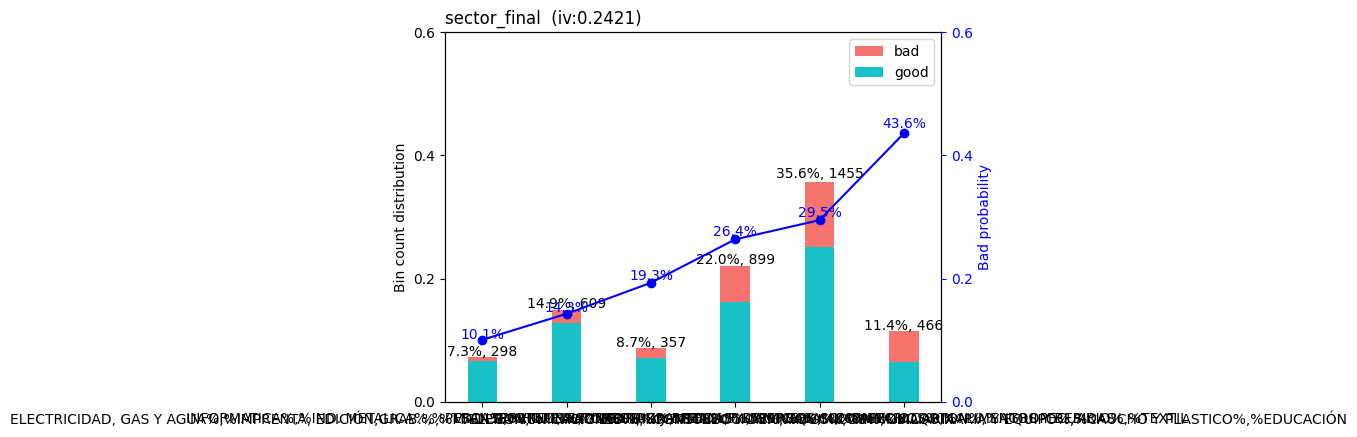

In [43]:
# Obtener el gráfico para la variable 'sector_final'
fig_sector_final = sc.woebin_plot(bins, ['sector_final'])

# Mostrar el gráfico
plt.show()

4. Modelo RL: modelo final

SE ESTÁ CALCULANDO CON `y_train` y no con `y_train_woe`

In [46]:
import statsmodels.api as sm

# Suponiendo que 'train_woe' es el DataFrame que contiene las variables transformadas de WoE y 'target_y' es la variable objetivo

# Añadir intercepto al conjunto de datos
train_woe['Intercept'] = 1

# Lista de variables predictoras en el modelo
predictors = [
    'sector_final_woe',
    'tipocontribuyente_woe',
    'NumeroTrabajadores_woe',
    'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M_woe',
    'MAX_CNT_ENTIDADES_SSFF_06M_woe',
    'SD_MAX_DIAS_MORA_SSFF_06M_woe',
    'CAT_PRODUCTOS_SSFF_01M_woe',
    'MAX_X_CLASIF_12M_woe',
    'ANTIGUEDAD_RCC_01M_woe',
    'EF_VAR_INMUEBLE_MAQ_EQUIPO_2a_woe',
    'EF_DIF_PROMEDIO_PAGOS_DIAS_2a_woe',
    'EF_COBERTURA_SERVICIO_DEUDA_1a_woe',
    'EF_Cajasbancos_PasivoExigible_1a_woe',
    'EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a_woe'
]

# Ajustar el modelo de regresión logística
model = sm.Logit(y_train, train_woe[predictors])

# Obtener los resultados del modelo
result = model.fit()

# Imprimir los resultados del modelo
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.417836
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               target_y   No. Observations:                 4084
Model:                          Logit   Df Residuals:                     4070
Method:                           MLE   Df Model:                           13
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                  0.2686
Time:                        20:05:23   Log-Likelihood:                -1706.4
converged:                       True   LL-Null:                       -2333.2
Covariance Type:            nonrobust   LLR p-value:                5.497e-260
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
sector_final_woe

Anova

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular los valores de VIF
vif_data = train_woe[predictors]  # Subset de datos con las variables predictoras
vif_data['Intercept'] = 1  # Agregar una columna de intercepto
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

# Imprimir los resultados en formato de tabla
print(vif)


                                             Variable       VIF
0                                    sector_final_woe  1.116057
1                               tipocontribuyente_woe  1.022276
2                              NumeroTrabajadores_woe  1.070585
3   MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTF...  1.396876
4                      MAX_CNT_ENTIDADES_SSFF_06M_woe  1.377645
5                       SD_MAX_DIAS_MORA_SSFF_06M_woe  1.534047
6                          CAT_PRODUCTOS_SSFF_01M_woe  1.336434
7                                MAX_X_CLASIF_12M_woe  1.138134
8                              ANTIGUEDAD_RCC_01M_woe  1.016590
9                   EF_VAR_INMUEBLE_MAQ_EQUIPO_2a_woe  1.034480
10                  EF_DIF_PROMEDIO_PAGOS_DIAS_2a_woe  1.027074
11                 EF_COBERTURA_SERVICIO_DEUDA_1a_woe  1.109715
12               EF_Cajasbancos_PasivoExigible_1a_woe  1.113855
13        EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a_woe  1.024254
14                                      

C:\Users\ANDREU\AppData\Local\Temp\ipykernel_28608\3842925374.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_data['Intercept'] = 1  # Agregar una columna de intercepto


Gini

In [48]:
from sklearn.metrics import roc_auc_score

# Calcular el índice de Gini para el conjunto de entrenamiento
train_gini = 2 * roc_auc_score(train_woe['target_y'], result.predict(train_woe[predictors])) - 1

# Calcular el índice de Gini para el conjunto de prueba
test_gini = 2 * roc_auc_score(test_woe['target_y'], result.predict(test_woe[predictors])) - 1

# Calcular el índice de Gini para el conjunto de retroceso
back_gini = 2 * roc_auc_score(back_woe['target_y'], result.predict(back_woe[predictors])) - 1

# Crear un DataFrame con los resultados
gini_df = pd.DataFrame({
    "train_": [train_gini],
    "test_": [test_gini],
    "back_": [back_gini]
}, index=["Gini"])

# Imprimir los resultados en formato de tabla
print(gini_df)


KeyError: 'target_y'